# Housing price prediction
## 2022-12-05

[Link to notebooks](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/code?competitionId=5407&sortBy=voteCount)

In [193]:
import warnings
from typing import List, Optional

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [99]:
data = pd.read_csv("./data/housing_price.csv")

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Hypothesis
Features that influence house price the most are its built year and area and yard area.  

### First EDA
Let's take a quick look at the most interesting features and evaluate feature engineering opportunities.

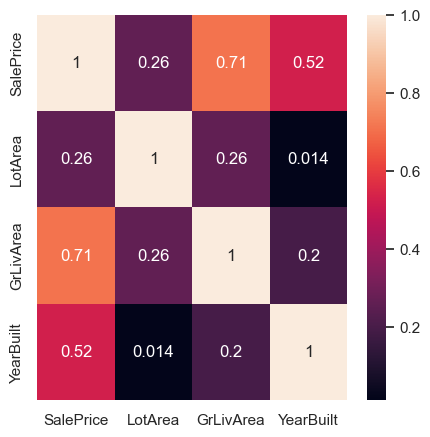

In [101]:
# Looking at the correlation between our hypothesis features
plt.figure(figsize=(5, 5))
corr = data[["SalePrice", "LotArea", "GrLivArea", "YearBuilt"]].corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_84811/1418481590.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


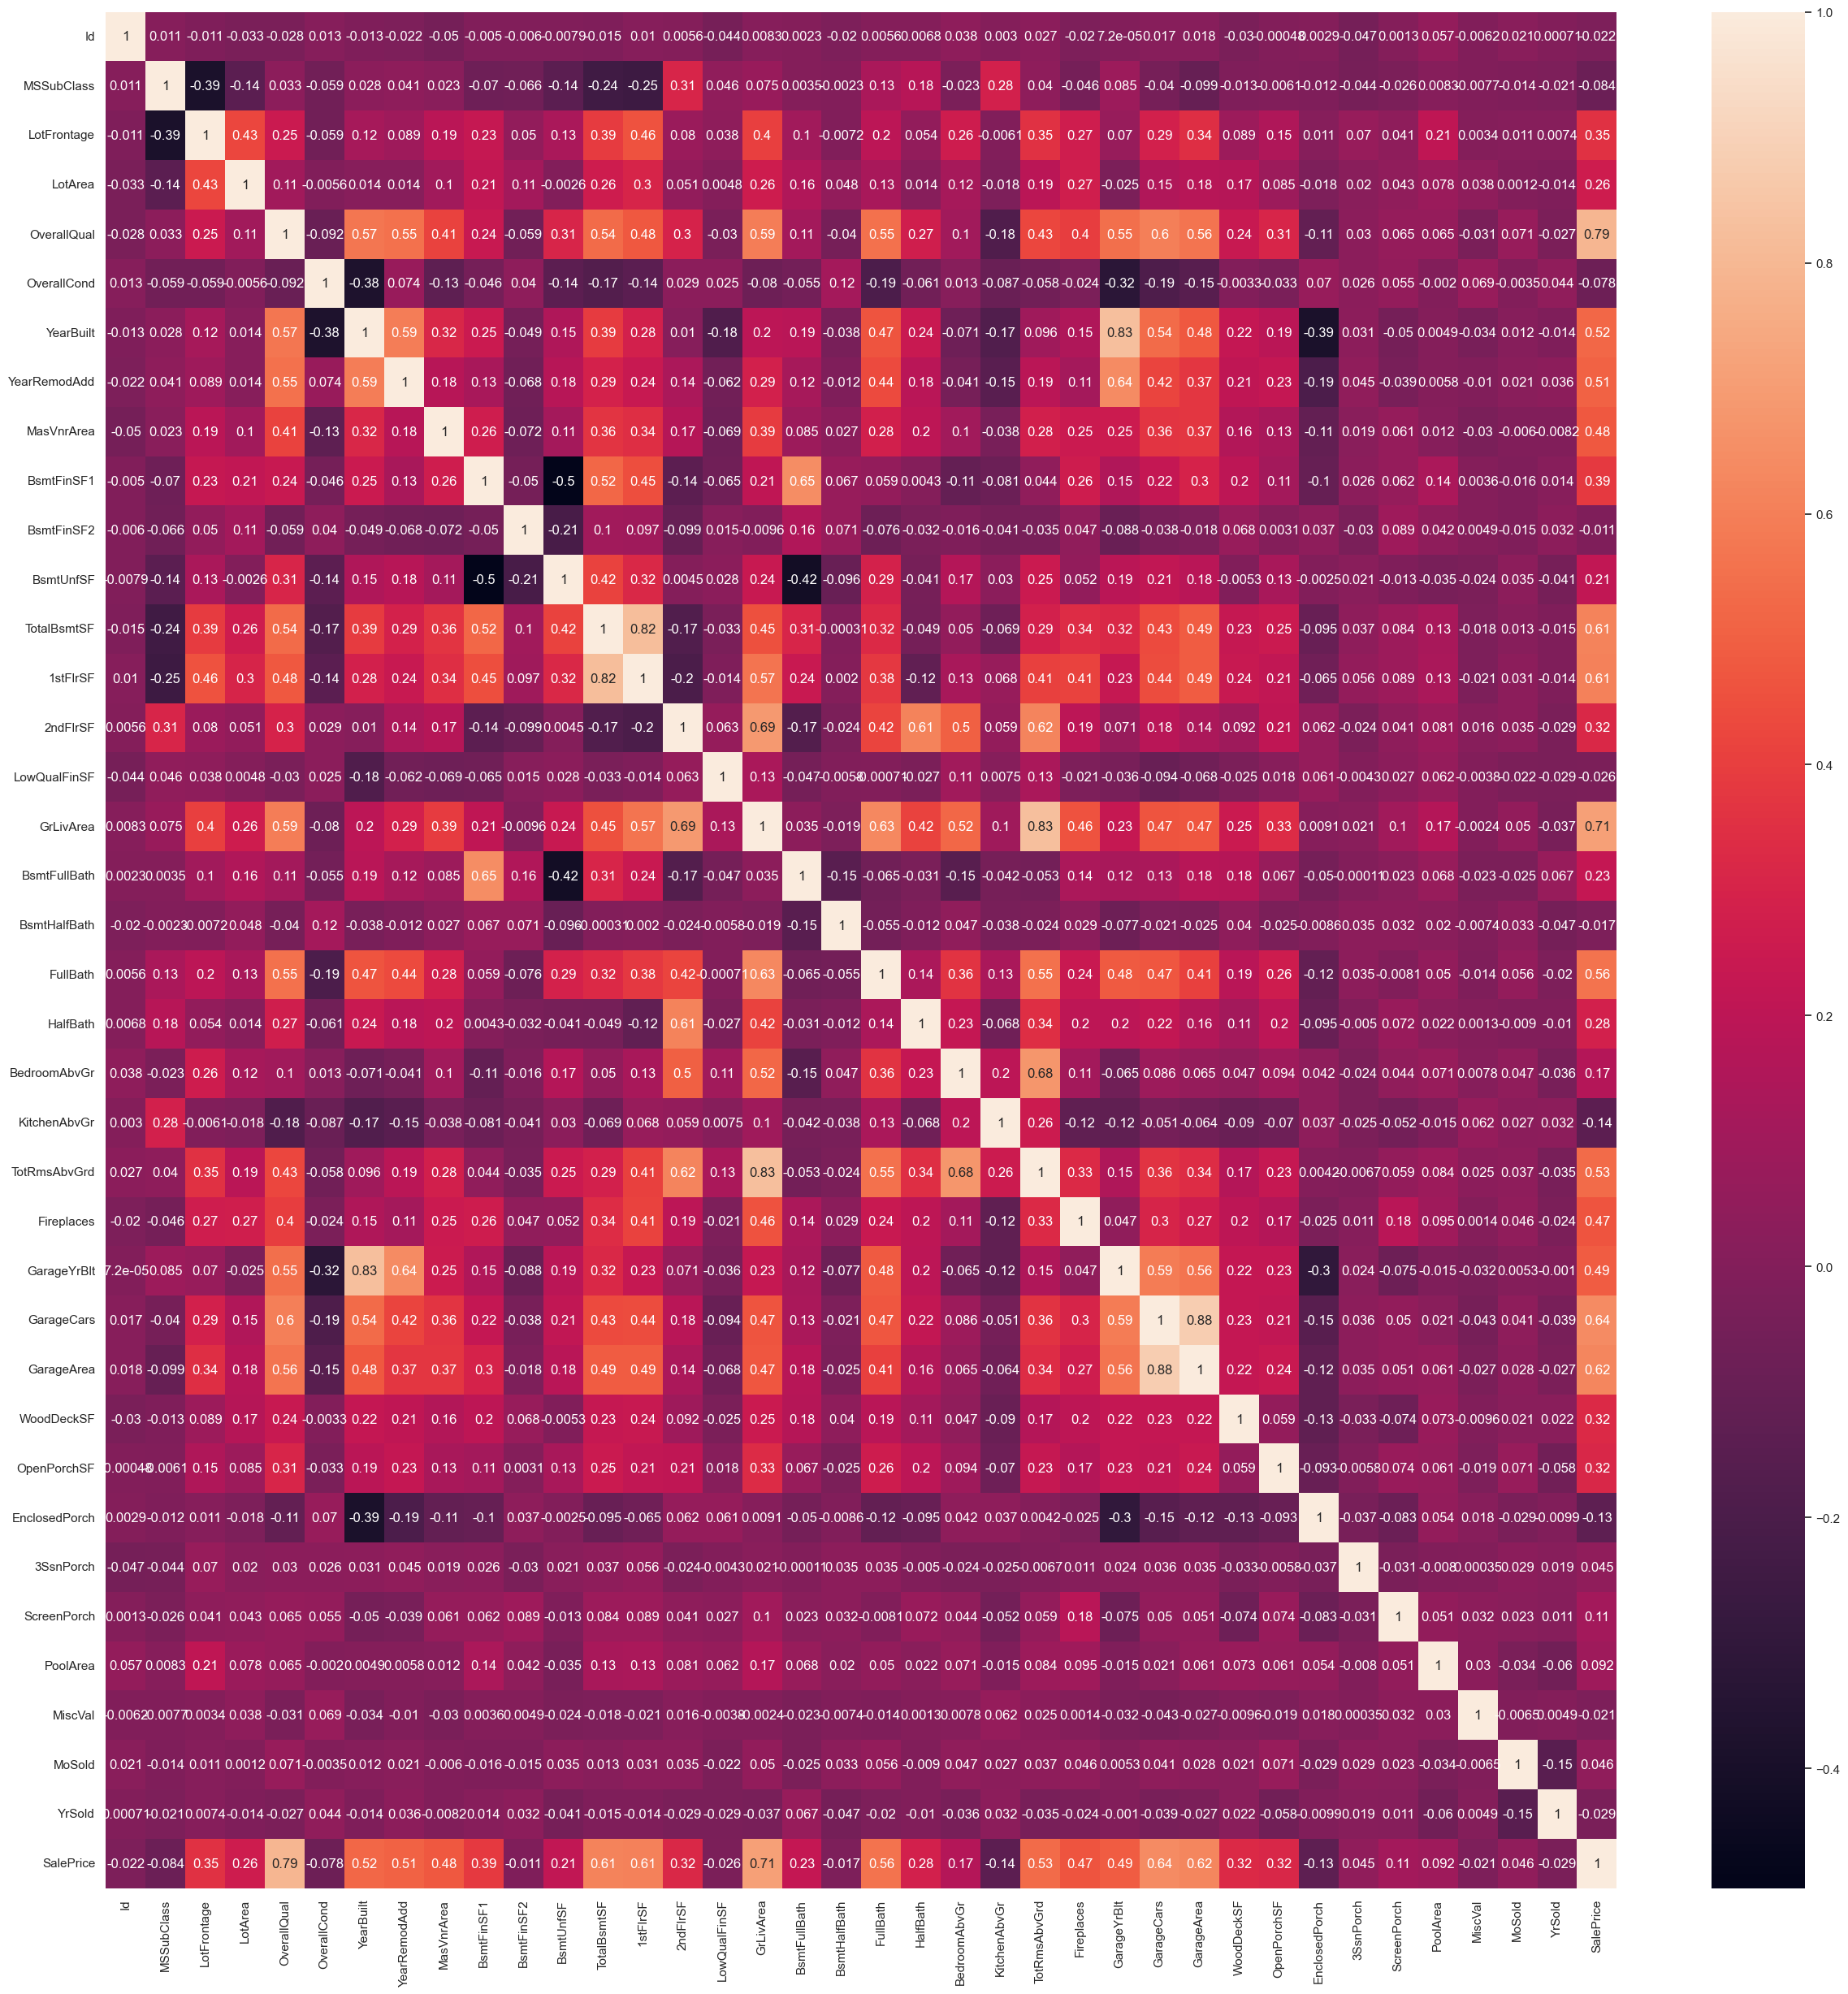

In [102]:
plt.figure(figsize=(30, 30))
corr = data.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

From the correlation plot we can see that there are multiple features that correlate the most with the `SalePrice` feature: `OverallCond`, `GrLiveArea`, `GrageCars` and `GarageArea`. There are also couple of features that have large postivie correlation between them: `GarageCars` and `GarageArea`, `GrLiveArea` and `TotRmsAbvGr`, `TotalBsmtSF` and `1stFlrSF`, `YearBuilt` and `GarageYrBlt`.

After looking at numeric features, let's take a look into categorical features

In [103]:
data.select_dtypes(include=["object"]).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

First, let's take a look into couple of the most interesting features: `FireplaceQu`, `HouseStyle`, `MSZoning`, `Street`, `Condition1` and `Condition2`.

In [104]:
sampled_categorical_data = data[
    ["FireplaceQu", "HouseStyle", "MSZoning", "Street", "Condition1", "Condition2", "Neighborhood"]
]
sampled_categorical_data

FireplaceQu HouseStyle MSZoning Street Condition1 Condition2 Neighborhood
0            NaN     2Story       RL   Pave       Norm       Norm      CollgCr
1             TA     1Story       RL   Pave      Feedr       Norm      Veenker
2             TA     2Story       RL   Pave       Norm       Norm      CollgCr
3             Gd     2Story       RL   Pave       Norm       Norm      Crawfor
4             TA     2Story       RL   Pave       Norm       Norm      NoRidge
...          ...        ...      ...    ...        ...        ...          ...
1455          TA     2Story       RL   Pave       Norm       Norm      Gilbert
1456          TA     1Story       RL   Pave       Norm       Norm       NWAmes
1457          Gd     2Story       RL   Pave       Norm       Norm      Crawfor
1458         NaN     1Story       RL   Pave       Norm       Norm        NAmes
1459         NaN     1Story       RL   Pave       Norm       Norm      Edwards

[1460 rows x 7 columns]

<AxesSubplot: xlabel='MSZoning', ylabel='count'>

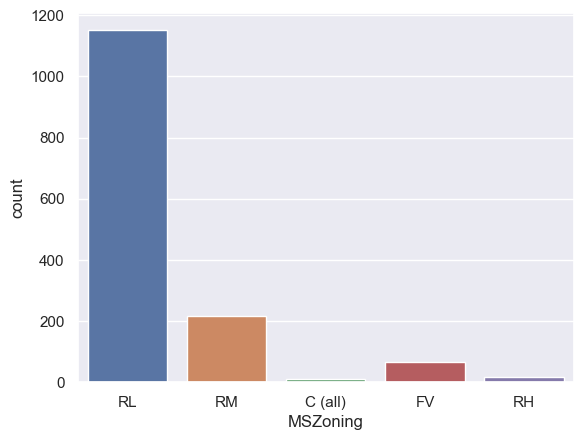

In [105]:
sns.countplot(data=sampled_categorical_data, x="MSZoning")

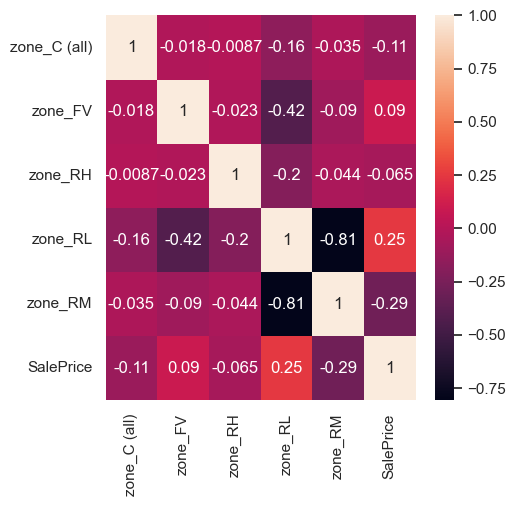

In [106]:
plt.figure(figsize=(5, 5))
corr = pd.concat(
    [pd.get_dummies(sampled_categorical_data["MSZoning"], prefix="zone"), data[["SalePrice"]]],
    axis=1,
).corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

From the correlation plot above, we can see that if house is in `Residential Low Density` area it is has higher price and if it is in `Residential Medium Density` it has a lower price. 

<AxesSubplot: xlabel='Condition1', ylabel='count'>

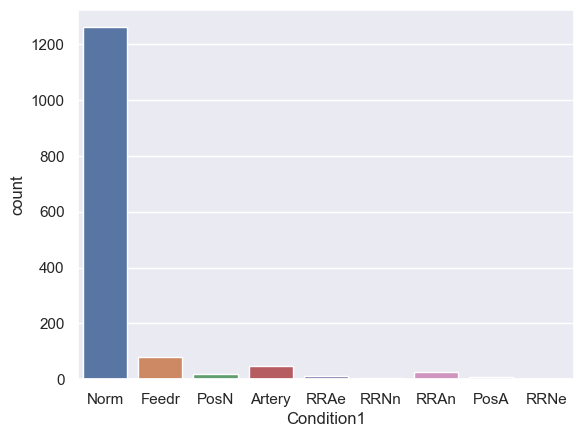

In [107]:
sns.countplot(data=sampled_categorical_data, x="Condition1")

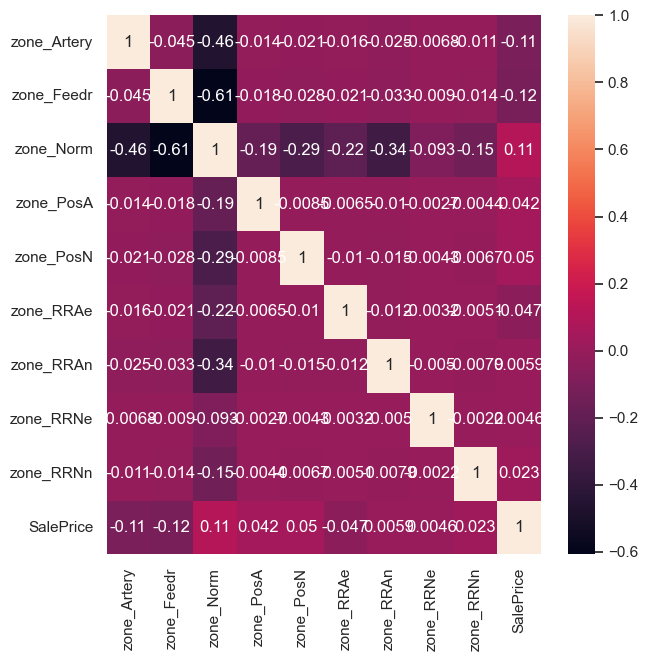

In [108]:
plt.figure(figsize=(7, 7))
corr = pd.concat(
    [pd.get_dummies(sampled_categorical_data["Condition1"], prefix="zone"), data[["SalePrice"]]],
    axis=1,
).corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

We can see that there is no major correlation between `Condition1` feature and `SalePrice`, thus we can ignore this categorical feature.

<AxesSubplot: xlabel='HouseStyle', ylabel='count'>

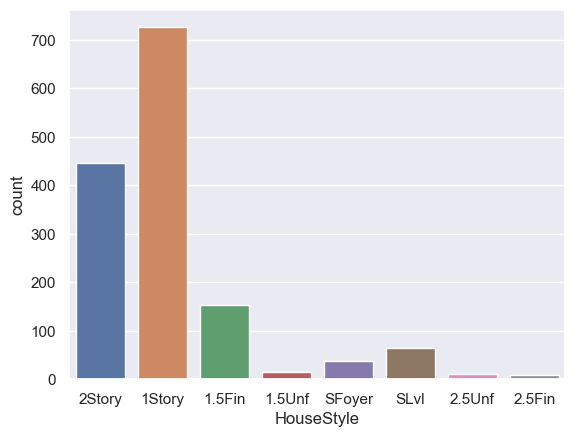

In [109]:
sns.countplot(data=sampled_categorical_data, x="HouseStyle")

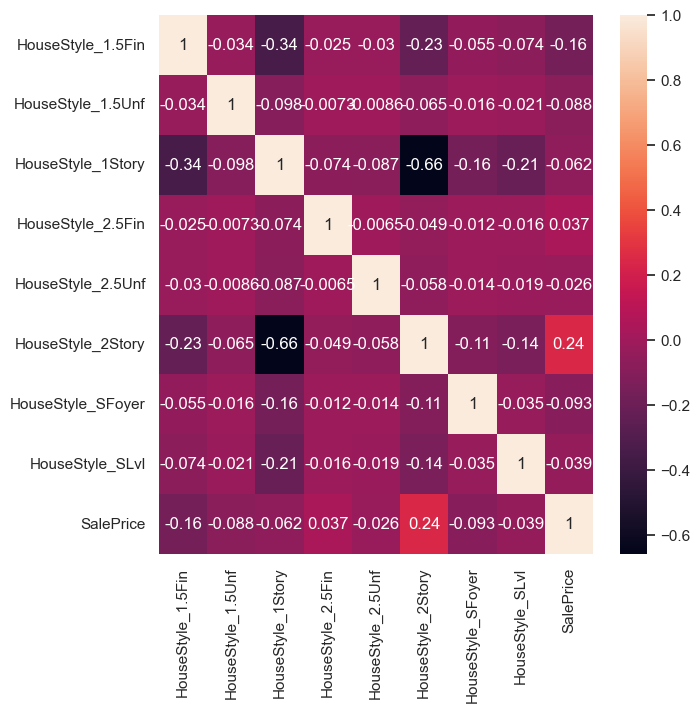

In [110]:
plt.figure(figsize=(7, 7))
corr = pd.concat(
    [
        pd.get_dummies(sampled_categorical_data["HouseStyle"], prefix="HouseStyle"),
        data[["SalePrice"]],
    ],
    axis=1,
).corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

We can see that there are no major correlations between `SalePrice` and other categorical features. We can ommit `HouseStyle` feature.

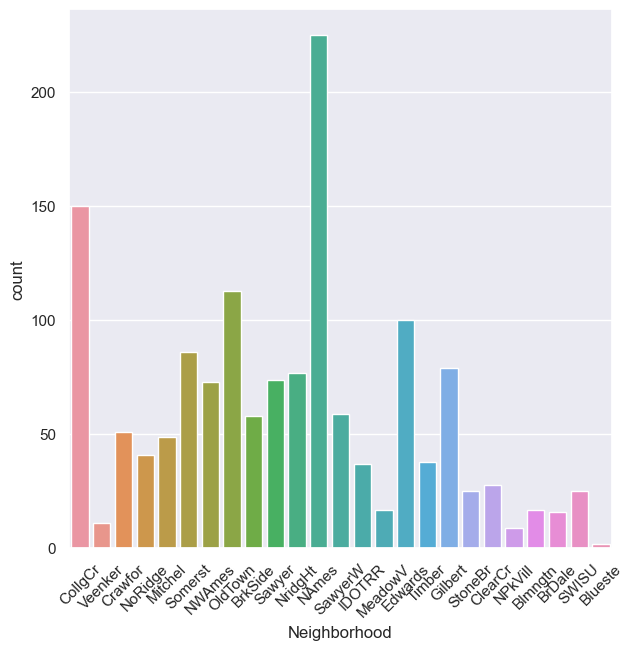

In [111]:
plt.figure(figsize=(7, 7))
sns.countplot(data=sampled_categorical_data, x="Neighborhood")
plt.xticks(rotation=45)
plt.show()

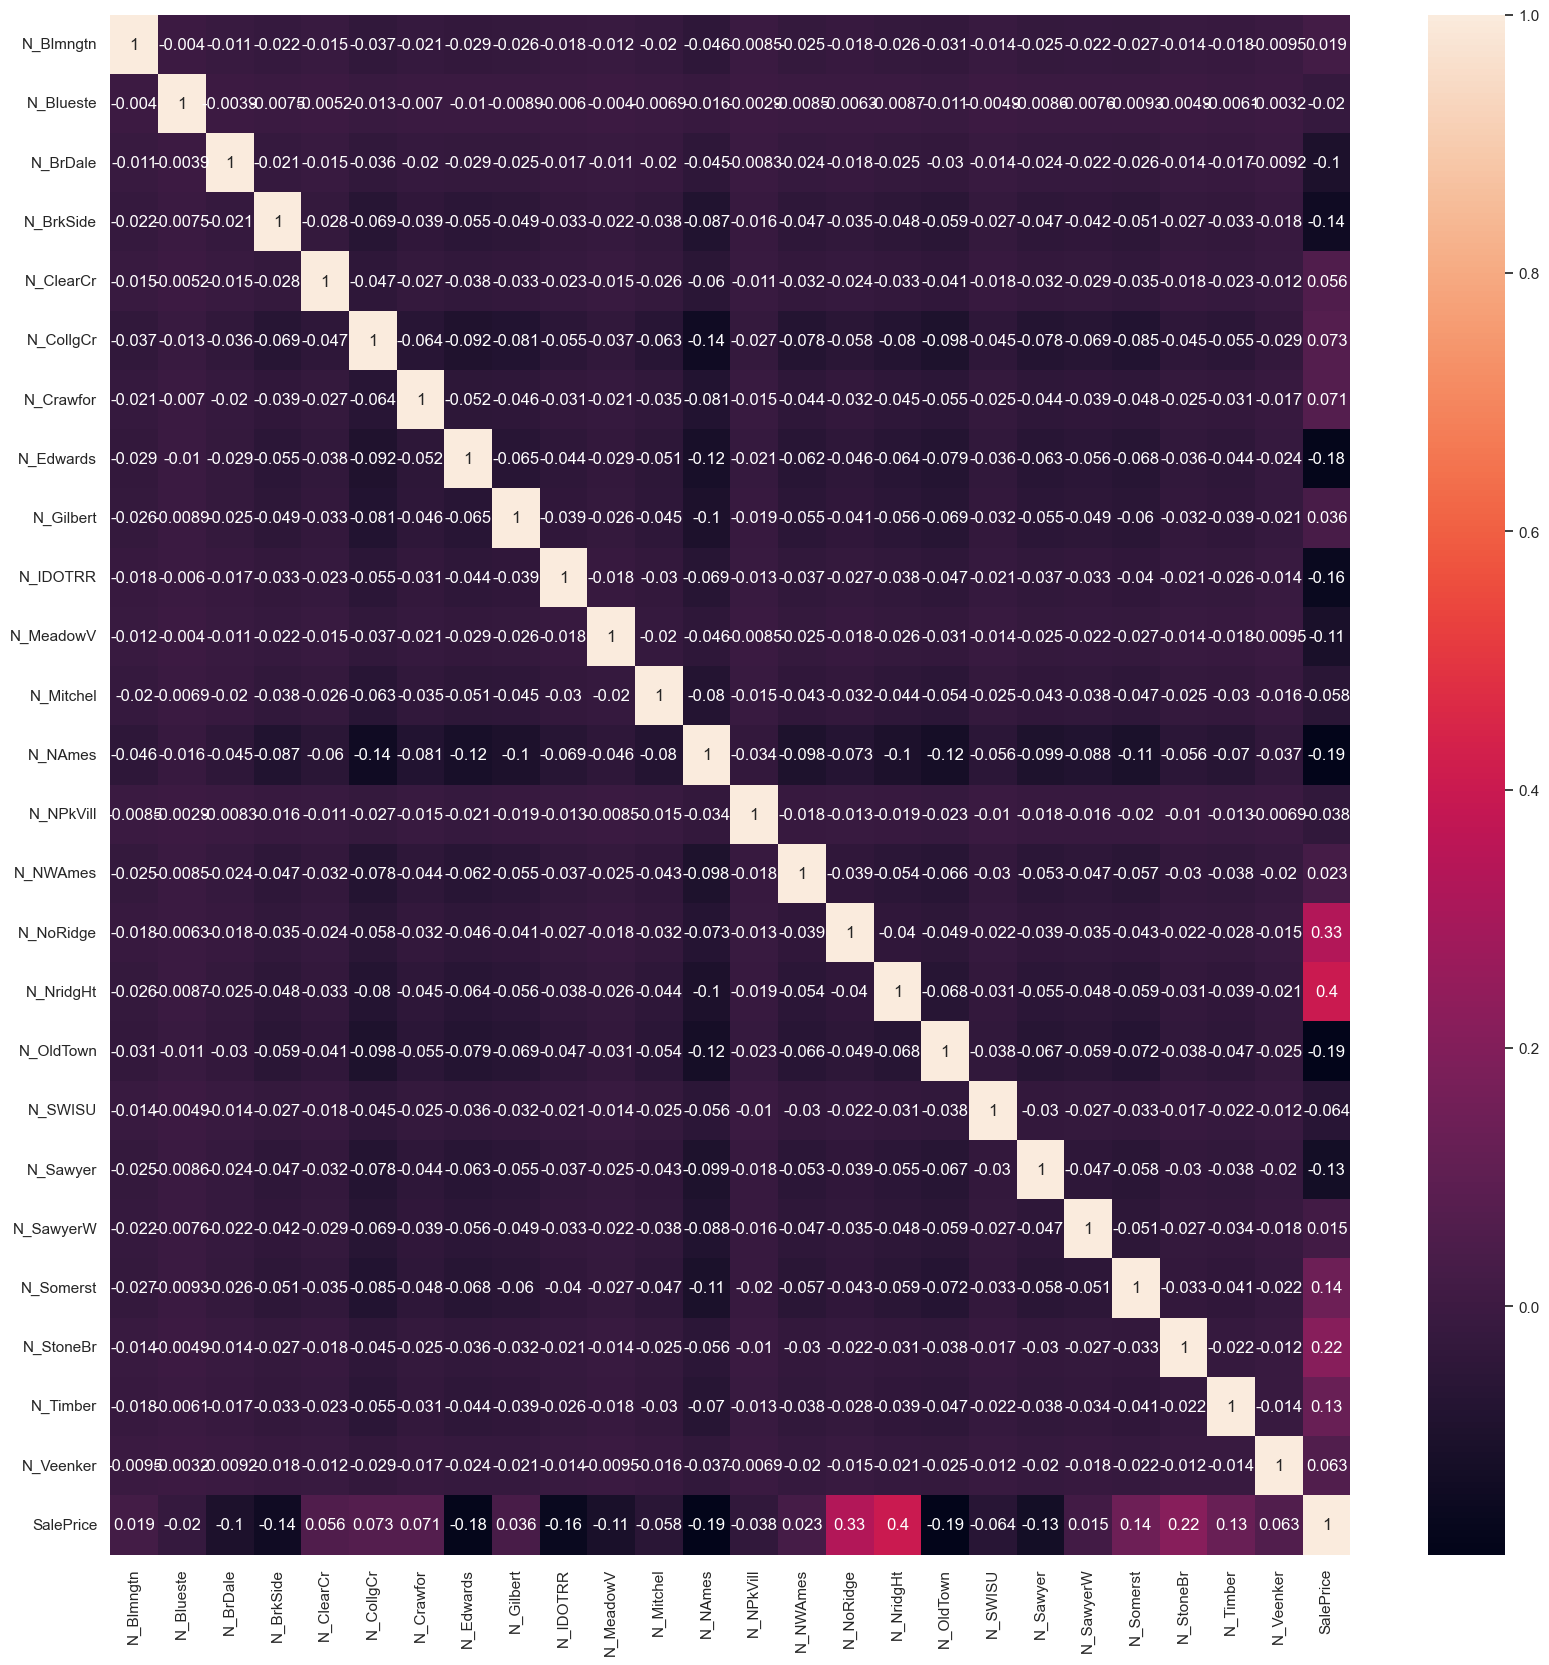

In [112]:
plt.figure(figsize=(20, 20))
corr = pd.concat(
    [pd.get_dummies(sampled_categorical_data["Neighborhood"], prefix="N"), data[["SalePrice"]]],
    axis=1,
).corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

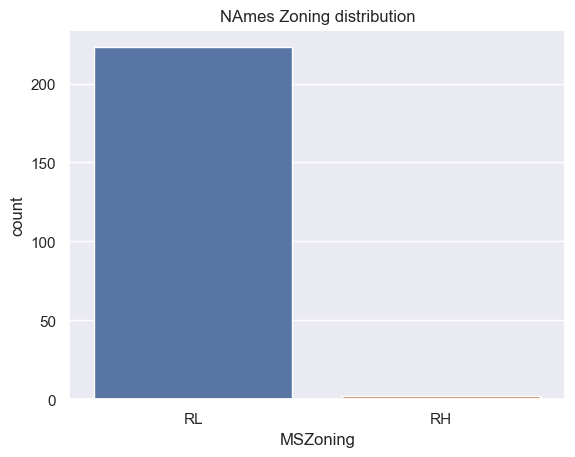

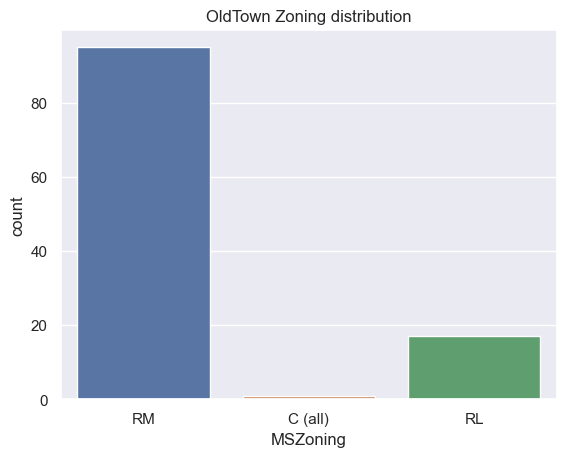

In [113]:
sns.countplot(
    data=sampled_categorical_data.loc[sampled_categorical_data["Neighborhood"] == "NAmes"],
    x="MSZoning",
)
plt.title("NAmes Zoning distribution")
plt.show()
sns.countplot(
    data=sampled_categorical_data.loc[sampled_categorical_data["Neighborhood"] == "OldTown"],
    x="MSZoning",
)
plt.title("OldTown Zoning distribution")
plt.show()

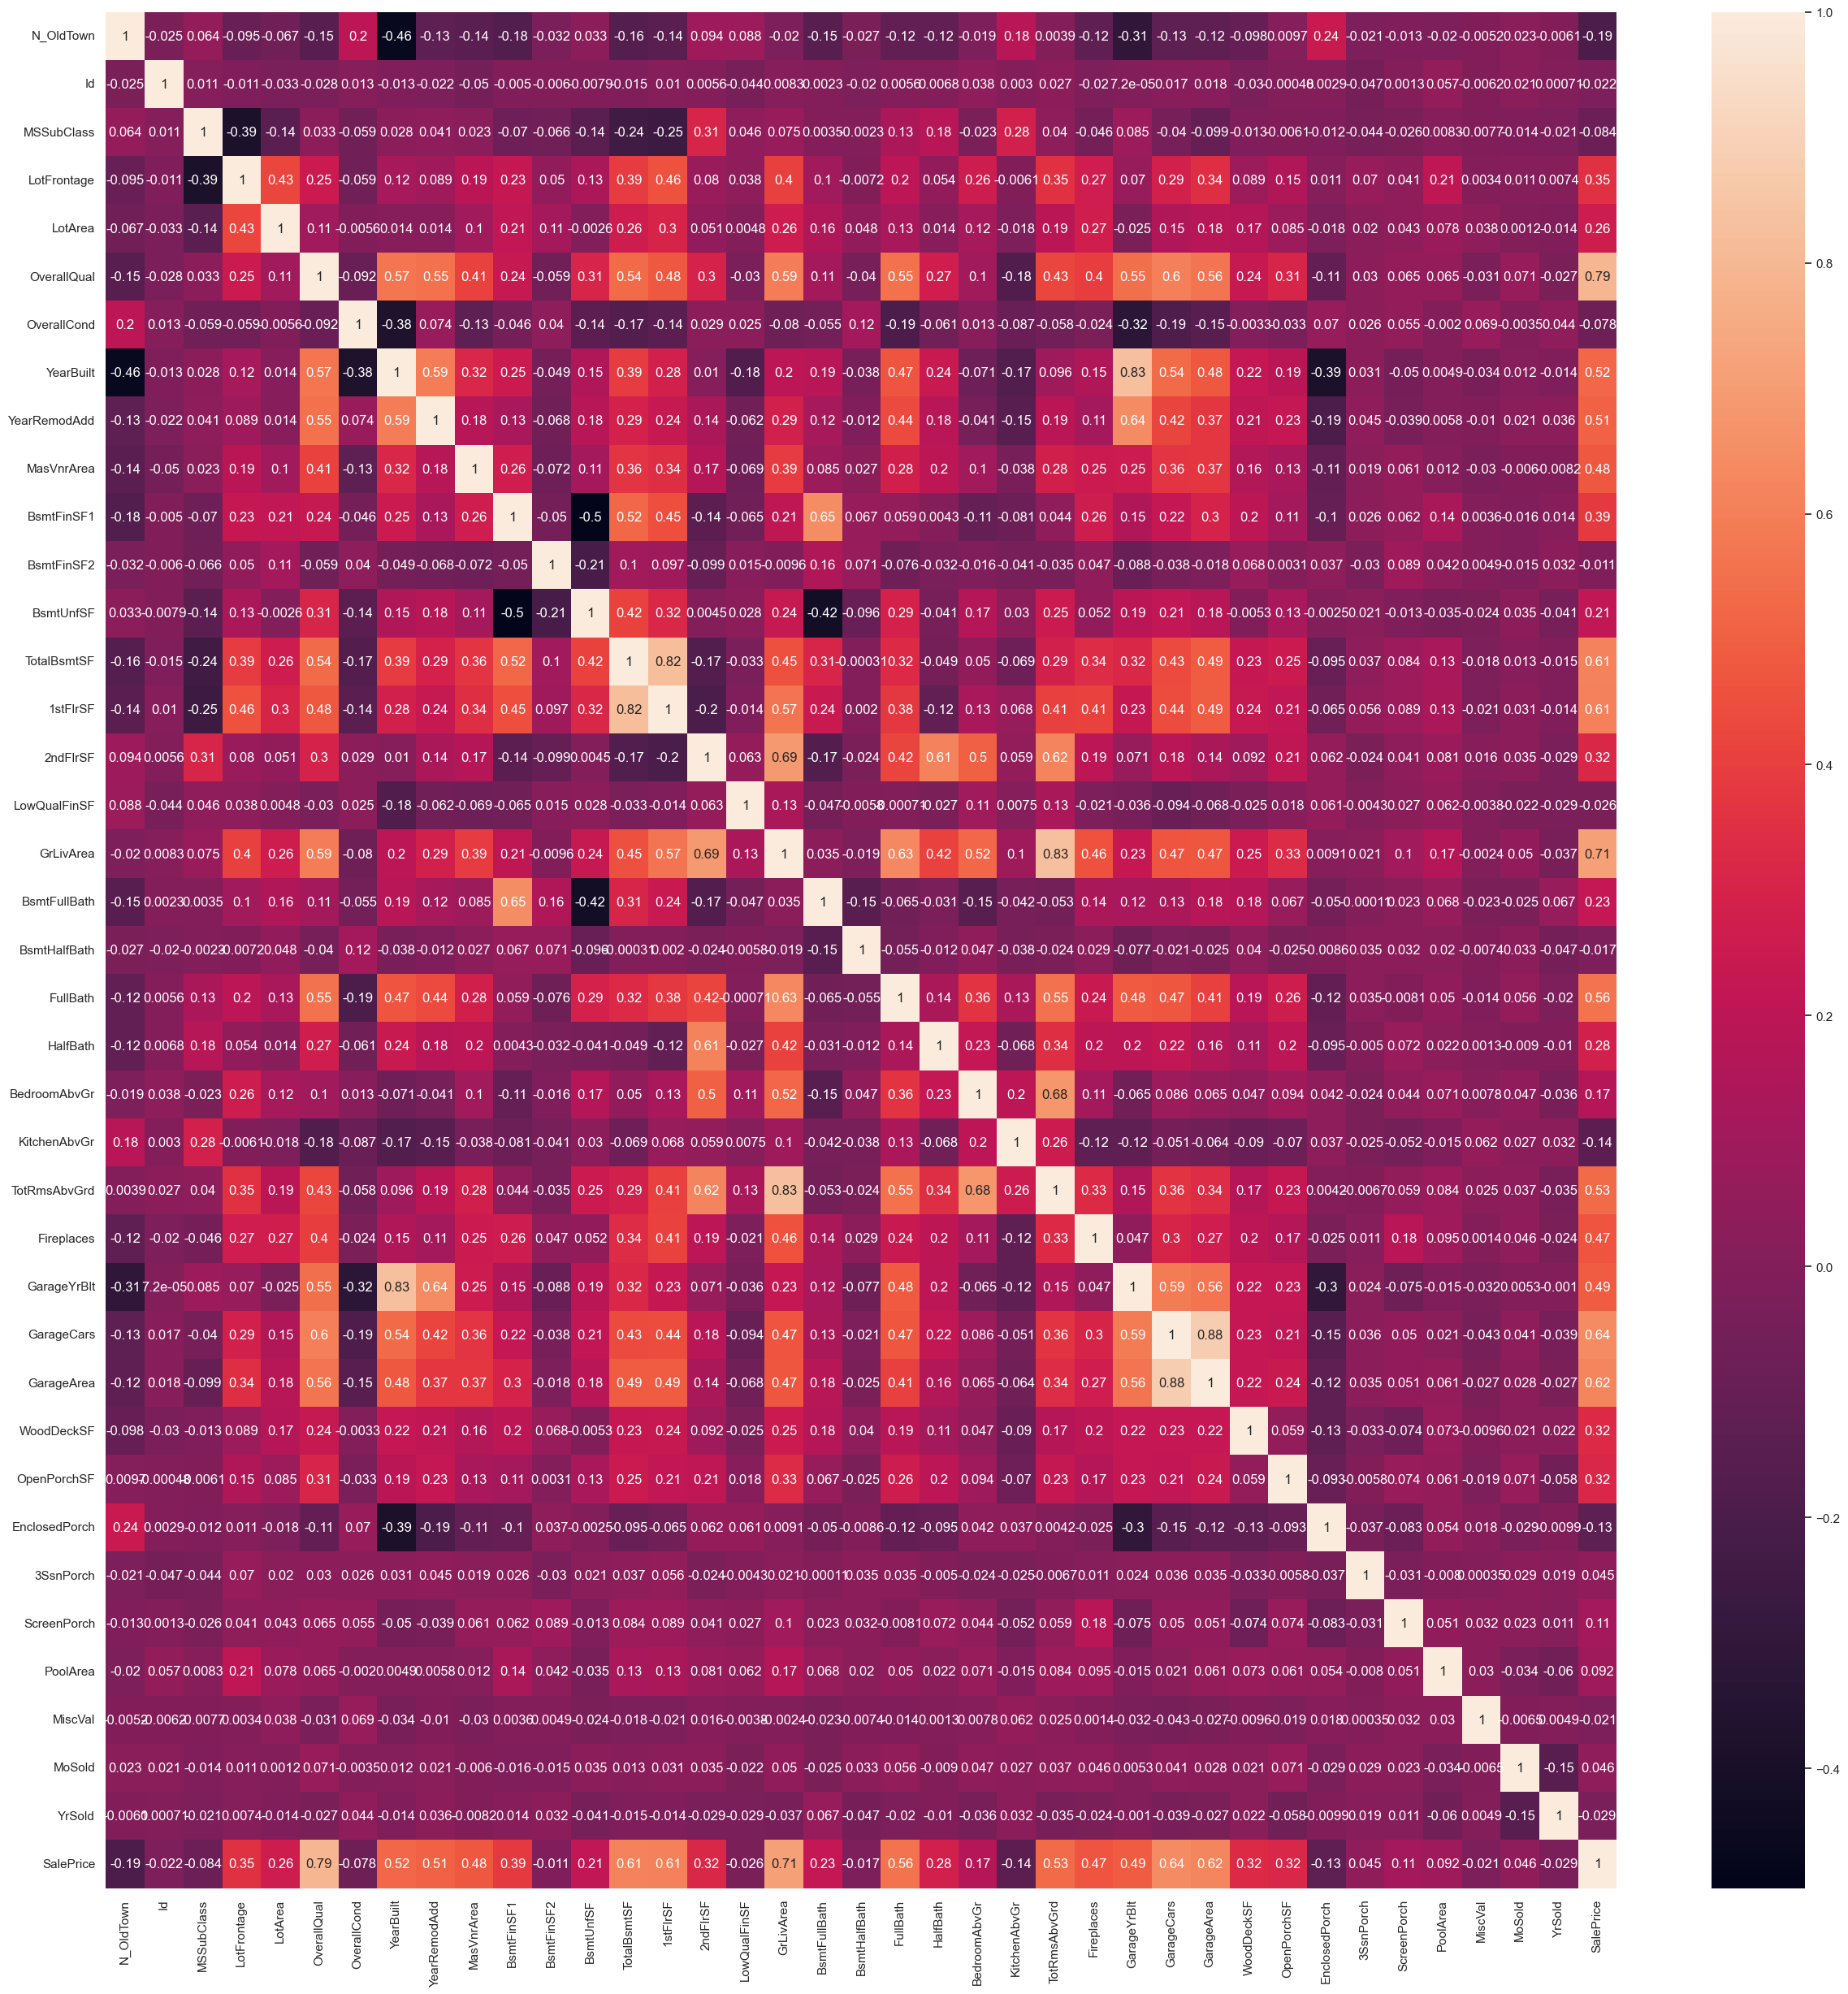

In [114]:
plt.figure(figsize=(30, 30))
corr = pd.concat(
    [
        pd.get_dummies(sampled_categorical_data["Neighborhood"], prefix="N")[["N_OldTown"]],
        data.select_dtypes(exclude=["object"]),
    ],
    axis=1,
).corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

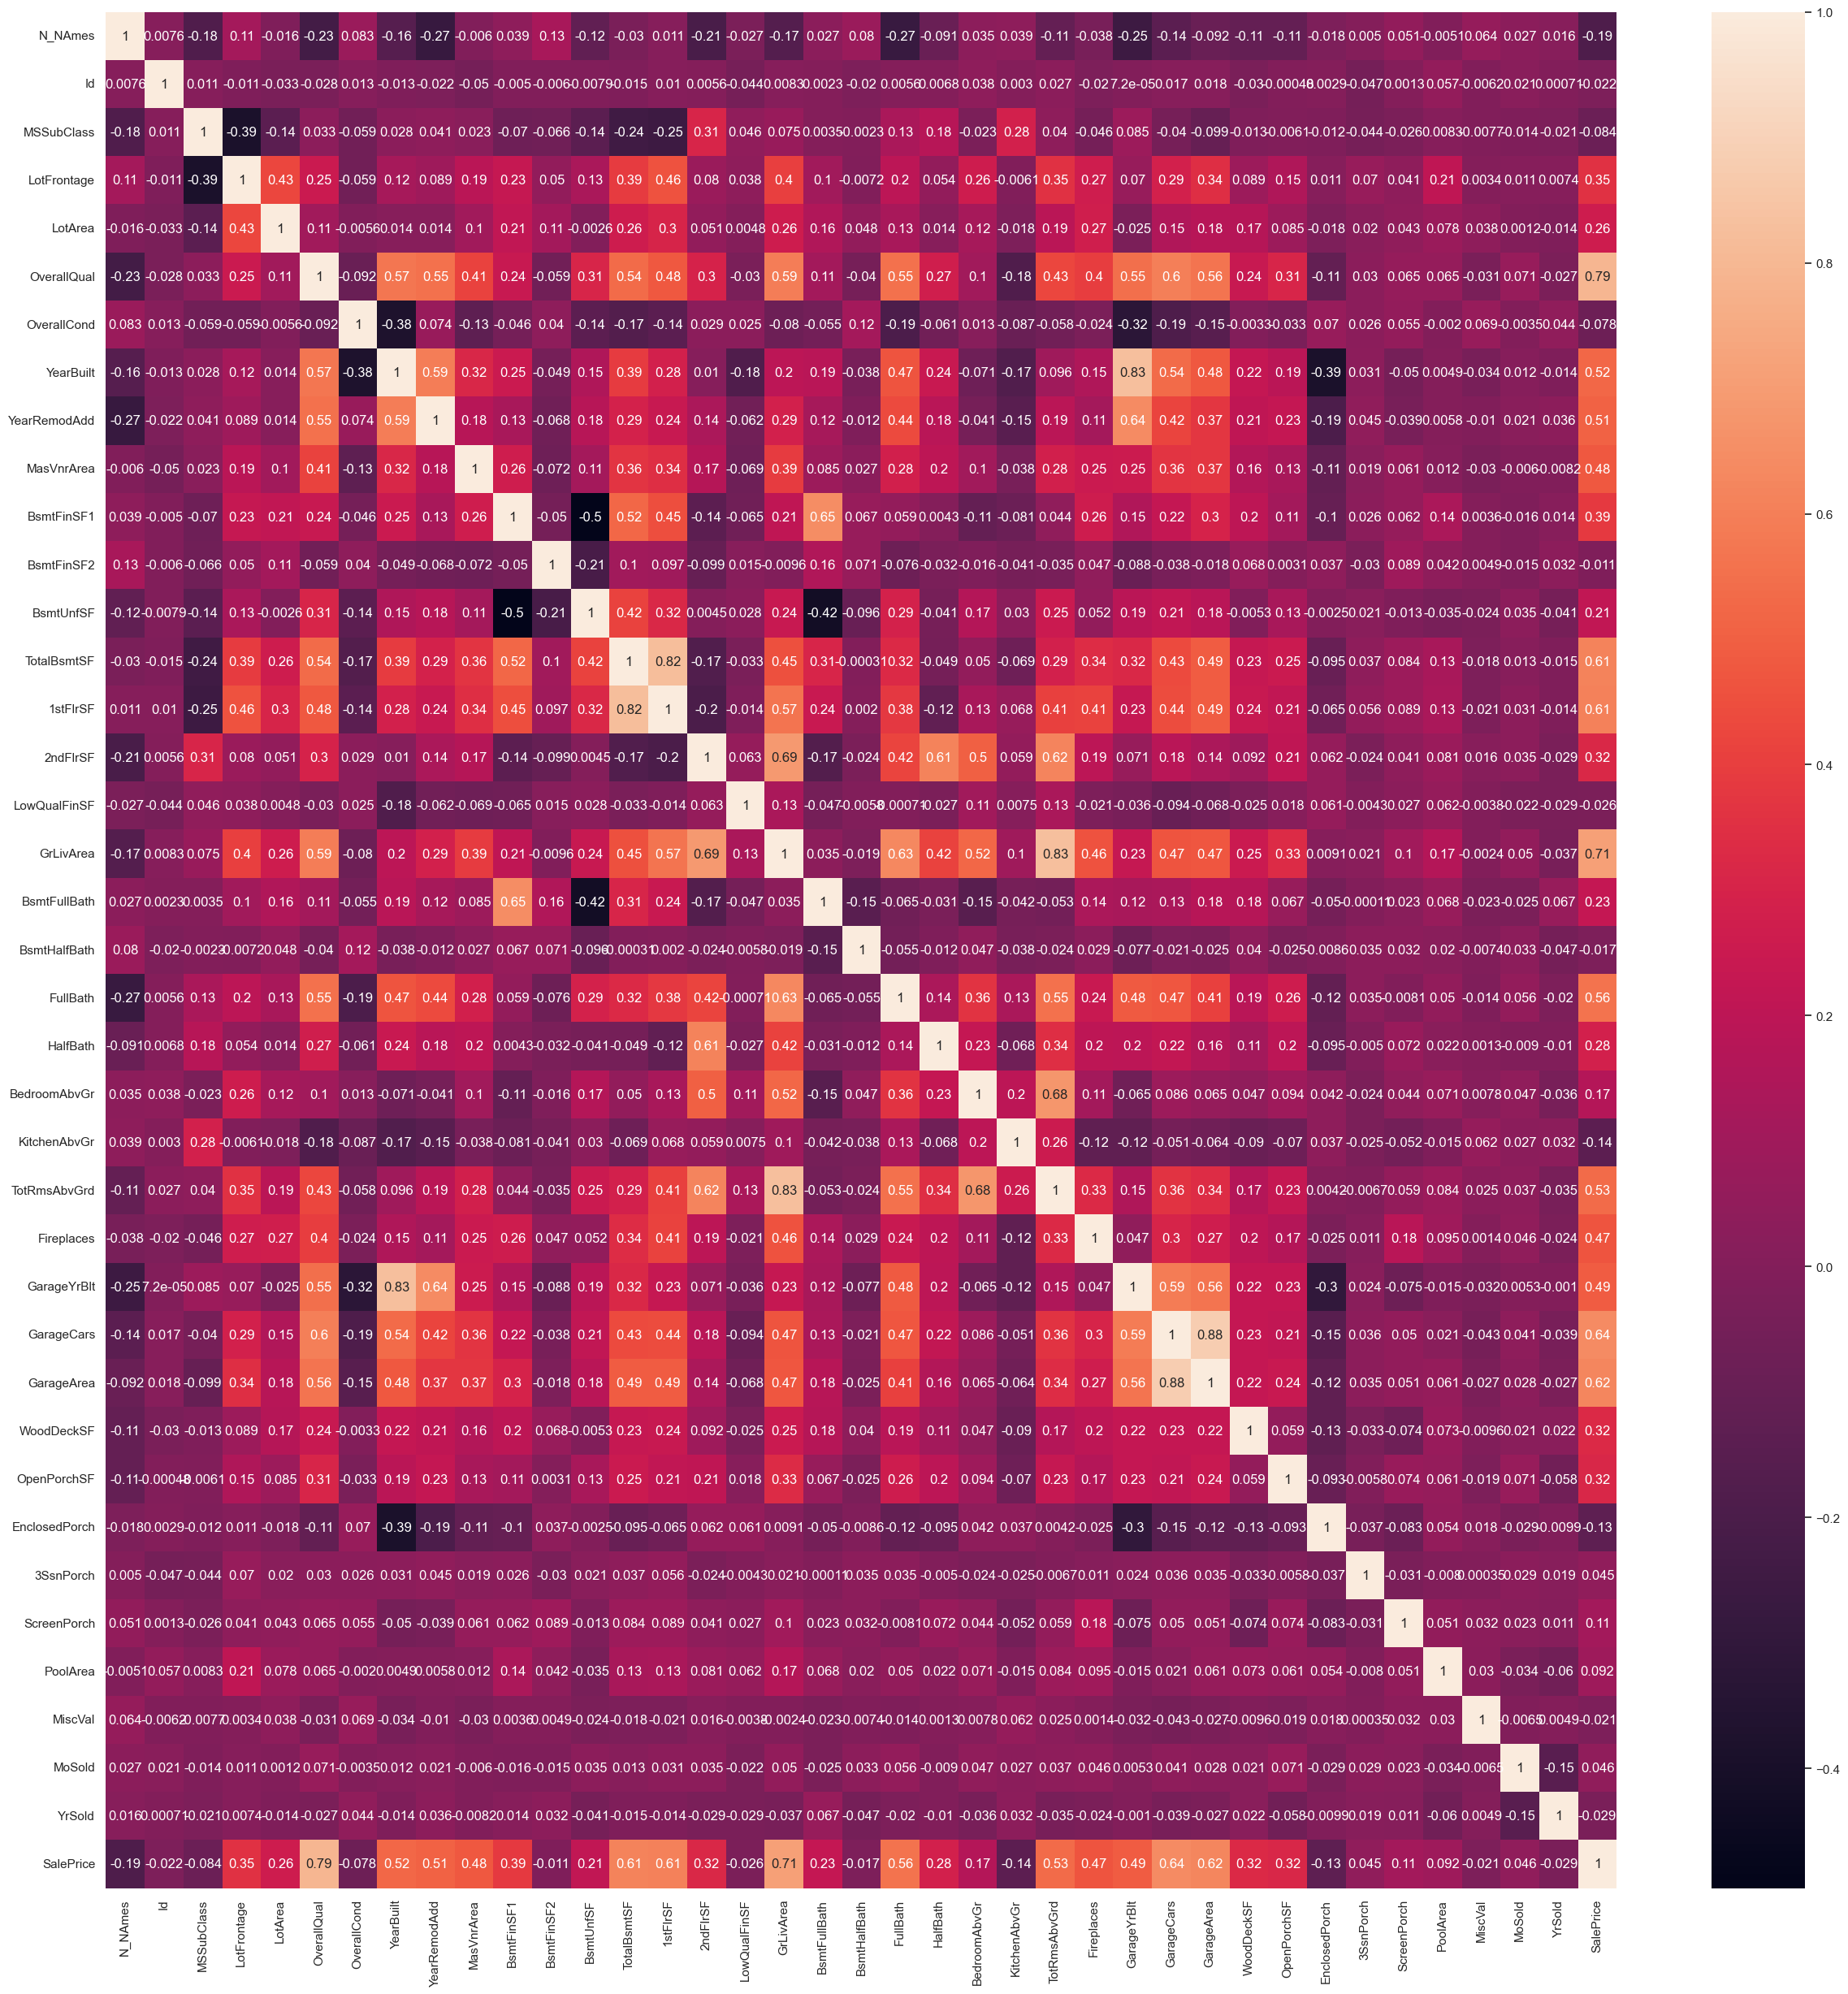

In [115]:
plt.figure(figsize=(30, 30))
corr = pd.concat(
    [
        pd.get_dummies(sampled_categorical_data["Neighborhood"], prefix="N")[["N_NAmes"]],
        data.select_dtypes(exclude=["object"]),
    ],
    axis=1,
).corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

In [116]:
data.groupby(by="Neighborhood")["YearBuilt"].mean()

Neighborhood
Blmngtn    2005.235294
Blueste    1980.000000
BrDale     1971.437500
BrkSide    1931.431034
ClearCr    1966.571429
CollgCr    1997.886667
Crawfor    1941.549020
Edwards    1955.970000
Gilbert    1998.253165
IDOTRR     1927.945946
MeadowV    1972.588235
Mitchel    1981.755102
NAmes      1959.995556
NPkVill    1976.444444
NWAmes     1975.630137
NoRidge    1995.439024
NridgHt    2005.675325
OldTown    1922.884956
SWISU      1925.240000
Sawyer     1963.675676
SawyerW    1988.559322
Somerst    2004.988372
StoneBr    1998.480000
Timber     1992.842105
Veenker    1982.363636
Name: YearBuilt, dtype: float64

From the analysis above we can see that there is no clear causation between `Neighborhood` and `SalePrice` features. We can only see correlation between some of the `Neighborhoods` and `SalePrice` but the corralation is probbably caused by the influnce of other features like `YearBuilt`. 

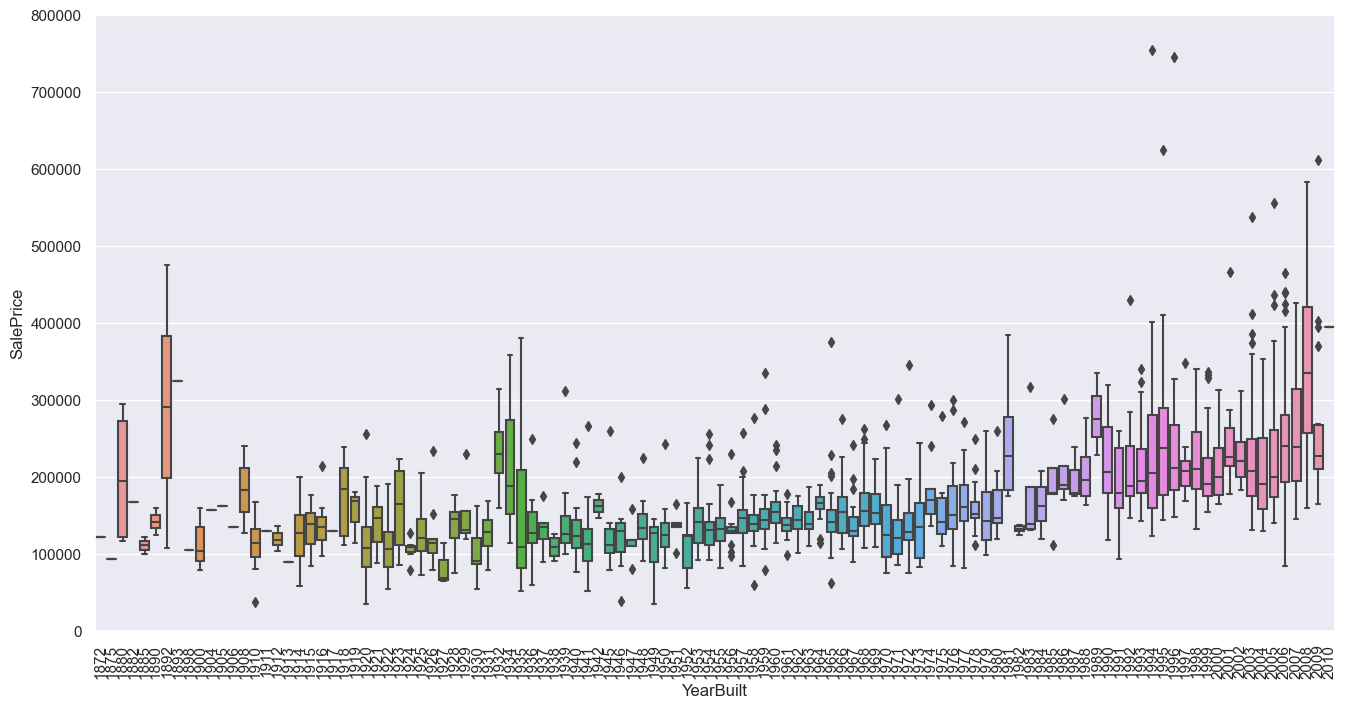

In [117]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x="YearBuilt", y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

From the boxplot above we can see that for house groups clustered by `YearBuilt` feature, `SalePrice` is all over the place, meaning that there are some other feature that influence the actual price of the house.

<AxesSubplot: xlabel='YearBuilt', ylabel='SalePrice'>

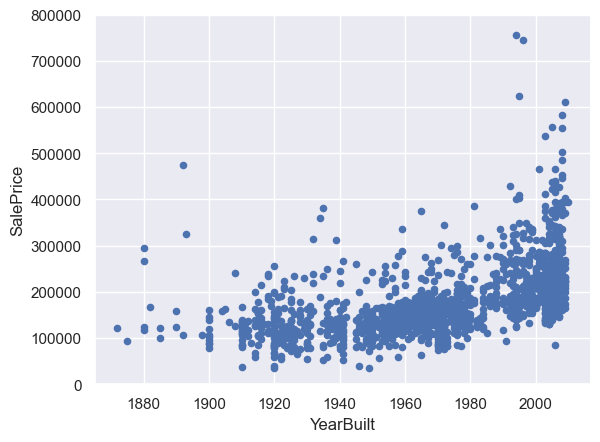

In [118]:
# scatter plot grlivarea/saleprice
var = "YearBuilt"
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

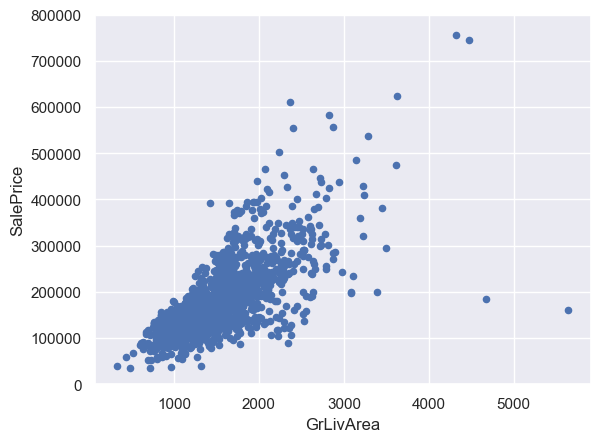

In [119]:
# scatter plot grlivarea/saleprice
var = "GrLivArea"
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

<AxesSubplot: xlabel='LotArea', ylabel='SalePrice'>

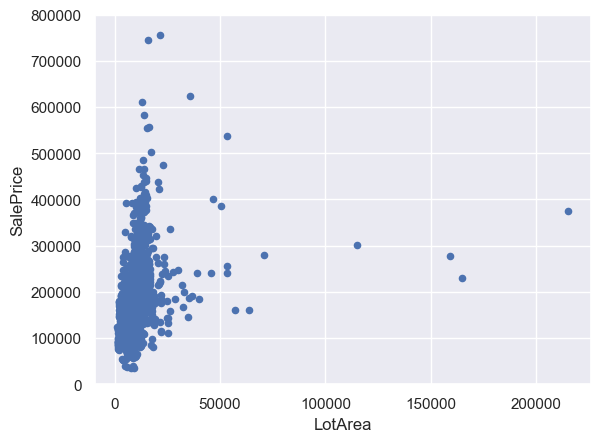

In [120]:
# scatter plot of lot area
var = "LotArea"
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

From the plots above we can see that despite `LotArea` having significant correlation with `SalePrice` it does not have obvious linear relationship with the price. `GrLivArea` is the feature that has obvious linear relationship and could be a great lead when selecting features to model with.

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


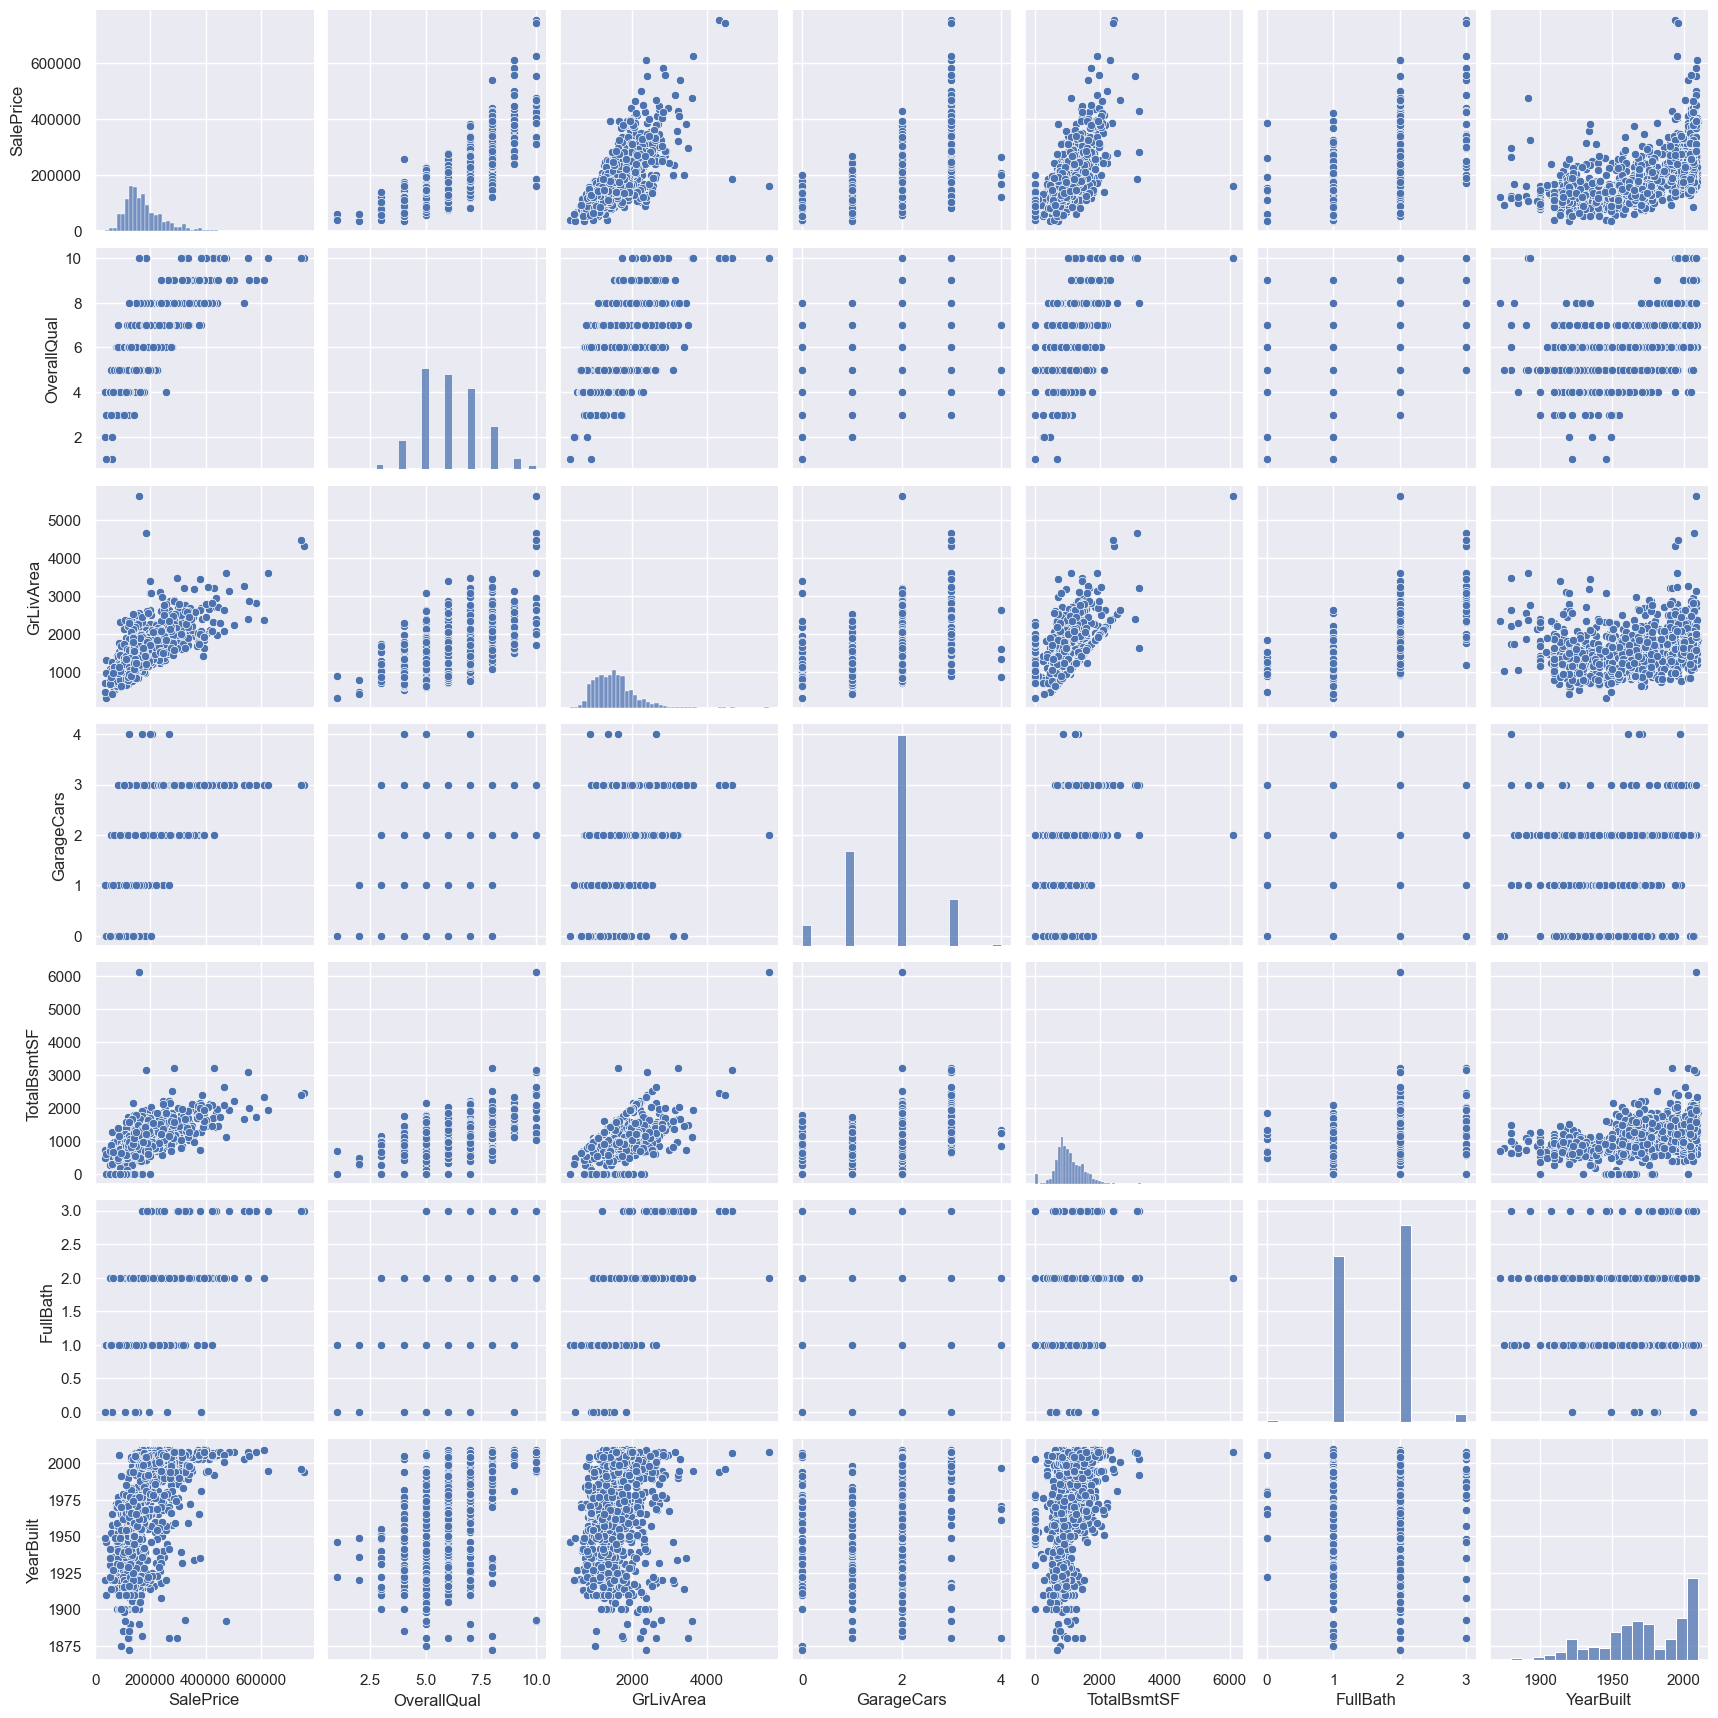

In [121]:
sns.set()
cols = [
    "SalePrice",
    "OverallQual",
    "GrLivArea",
    "GarageCars",
    "TotalBsmtSF",
    "FullBath",
    "YearBuilt",
]
sns.pairplot(data[cols], size=2.5)
plt.show();

### Creating baseline
For our baseline model, we are using a simple equation to determine the sale price of a house. We take an average price per square foot and multiply it by the inference house square footage `SqFootage`.
$$
f(\text{SqFootage}) = \frac{\sum frac{\text{SalePrice}}{\text{GrLivArea}}}{n} * \text{SqFootage}
$$

In [122]:
class BaselinePredictor:
    def __init__(self) -> None:
        self._avg_price_per_sq_footage = 0.0

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._avg_price_per_sq_footage = np.mean(y / X)

    def predict(self, X) -> np.ndarray:
        return X * self._avg_price_per_sq_footage

In [123]:
baseline = BaselinePredictor()
baseline.fit(data["GrLivArea"].values, data["SalePrice"].values)

data[["GrLivArea", "SalePrice"]].head(4)

GrLivArea  SalePrice
0       1710     208500
1       1262     181500
2       1786     223500
3       1717     140000

In [124]:
print(baseline.predict(1710))
print(baseline.predict(1262))

206179.62150528925
152162.97212846493


### Data cleaning 

In [125]:
# remove dublicates
print(f"Size before deduplication: {data.size}")
data = data.drop_duplicates()
print(f"Size after deduplication: {data.size}")

Size before deduplication: 118260
Size after deduplication: 118260


In [127]:
# checking for missing data

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Id                0  0.000000

In [128]:
data = data.drop((missing_data[missing_data["Total"] > 1]).index, 1)
data = data.drop(data.loc[data["Electrical"].isnull()].index)
data.isnull().sum().max()

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_84811/3537760437.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop((missing_data[missing_data["Total"] > 1]).index,1)


0

#### Removing outliers

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

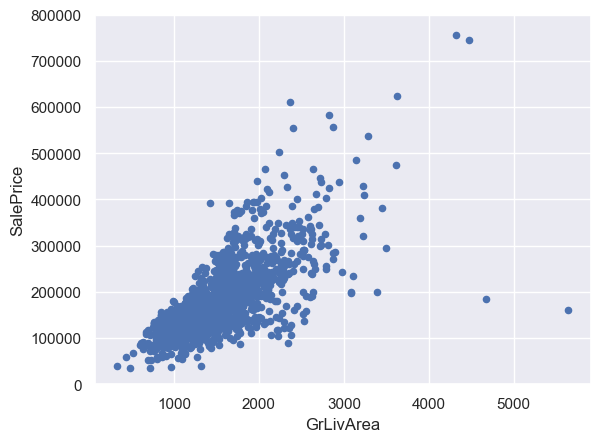

In [132]:
# scatter plot grlivarea/saleprice
var = "GrLivArea"
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

From the plot above, we can see that there are some interesting outliers when talking about `GrLivArea` feature. The houses with the huge square footage are too far from the other points and are most likely false advertisement. So we want to remove them

In [131]:
data.sort_values(by=["GrLivArea"], ascending=False)[:4]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
1298  1299          60       RL    63887   Pave      IR3         Bnk   
523    524          60       RL    40094   Pave      IR1         Bnk   
1182  1183          60       RL    15623   Pave      IR1         Lvl   
691    692          60       RL    21535   Pave      IR1         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
1298    AllPub    Corner       Gtl  ...             0         0           0   
523     AllPub    Inside       Gtl  ...             0         0           0   
1182    AllPub    Corner       Gtl  ...             0         0           0   
691     AllPub    Corner       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
1298      480       0       1    2008       New        Partial    160000  
523         0       0      10    2007       New        Partial    184750  
1182      555       0       7    2007        WD        Abnorml    745000  
691         0       0       1    2007        WD         Normal    755000  

[4 rows x 63 columns]

In [133]:
data = data.drop(data[data["Id"] == 524].index)
data = data.drop(data[data["Id"] == 1299].index)
data = data.drop(data[data["Id"] == 1183].index)
data = data.drop(data[data["Id"] == 692].index)

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

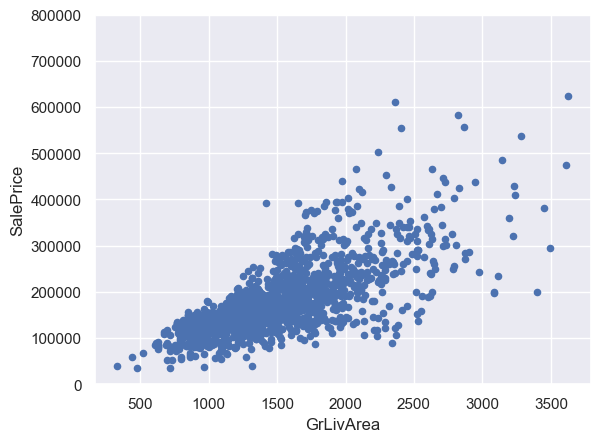

In [134]:
# scatter plot grlivarea/saleprice
var = "GrLivArea"
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

### Creating pipelines

In [135]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [209]:
cont_features = [
    "GrLivArea",
    "YearBuilt",
    "OverallQual",
    "OverallCond",
    "YearRemodAdd",
    "has_totalbsmtsf",
    "has_garagearea",
    "has_poolarea",
]
cat_features = ["Neighborhood", "HouseStyle"]
label = "SalePrice"

In [179]:
class ToBinaryFeaturesTransfromer(BaseEstimator, TransformerMixin):
    """Transformer that transforms continous or categorical data into binary features if needed

    Args:
        BaseEstimator (_type_): _description_
        TransformerMixin (_type_): _description_
    """

    def __init__(self, features: List[str]) -> None:
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        data = X.copy()
        for feature in self.features:
            data[f"has_{feature.lower()}"] = data[feature].apply(lambda x: int(x > 0))
        data.drop(self.features, axis=1)
        return data

In [154]:
df = data.copy()

tf = ToBinaryFeaturesTransfromer(["GarageArea", "TotalBsmtSF", "PoolArea"])

df = tf.transform(df)

df.head()

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... PoolArea MiscVal MoSold YrSold SaleType  \
0    Inside       Gtl  ...        0       0      2   2008       WD   
1       FR2       Gtl  ...        0       0      5   2007       WD   
2    Inside       Gtl  ...        0       0      9   2008       WD   
3    Corner       Gtl  ...        0       0      2   2006       WD   
4       FR2       Gtl  ...        0       0     12   2008       WD   

   SaleCondition  SalePrice  has_garagearea  has_totalbsmtsf has_poolarea  
0         Normal     208500               1                1            0  
1         Normal     181500               1                1            0  
2         Normal     223500               1                1            0  
3        Abnorml     140000               1                1            0  
4         Normal     250000               1                1            0  

[5 rows x 66 columns]

#### Building pipelines

In [210]:
cont_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")), ("one_hot_encode", OneHotEncoder())]
)

In [211]:
pipeline = Pipeline(
    [
        (
            "to_binary_features_transformer",
            ToBinaryFeaturesTransfromer(features=["GarageArea", "TotalBsmtSF", "PoolArea"]),
        ),
        (
            "ColumnTransformer",
            ColumnTransformer(
                [
                    ("cont_transformer", cont_pipeline, cont_features),
                    ("cat_transformer", cat_pipeline, cat_features),
                ]
            ),
        ),
        ("model", LinearRegression()),
    ]
)

#### Splitting data


In [212]:
train_df, test_df = train_test_split(data)
print("Train size: ", train_df.size)
print("Test size: ", test_df.size)

Train size:  68733
Test size:  22932


#### Training our models

In [213]:
# training baseline

baseline = BaselinePredictor()
baseline.fit(data["GrLivArea"].values, data["SalePrice"].values)

In [214]:
# training LinReg

pipeline.fit(train_df, train_df["SalePrice"].values)

Pipeline(steps=[('to_binary_features_transformer',
                 ToBinaryFeaturesTransfromer(features=['GarageArea',
                                                       'TotalBsmtSF',
                                                       'PoolArea'])),
                ('ColumnTransformer',
                 ColumnTransformer(transformers=[('cont_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GrLivArea', 'YearBuilt',
                                                   'OverallQual', 'OverallCond',
                                                   'YearRemodAdd',
                                                   'has_totalbsmtsf',
                                                   'has_garagearea',
                                                   'has_poolarea']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encode',
                                                                   OneHotEncoder())]),
                                                  ['Neighborhood',
                                                   'HouseStyle'])])),
                ('model', LinearRegression())])

#### Checking model peroformances

In [215]:
print("Baseline")
predictions = baseline.predict(test_df["GrLivArea"])
print("MAE: ", mean_absolute_error(test_df[label], predictions))
print("MSE: ", mean_squared_error(test_df[label], predictions))

Baseline
MAE:  33942.72458471623
MSE:  2364058044.9114327


In [216]:
print("LinearReg")
predictions = pipeline.predict(test_df)
print("MAE: ", mean_absolute_error(test_df[label], predictions))
print("MSE: ", mean_squared_error(test_df[label], predictions))

LinearReg
MAE:  22840.865654811198
MSE:  1148629995.8602648


#### Checking feature importance

In [217]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    # check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == "drop" or (hasattr(column, "__len__") and not len(column)):
            return []
        if trans == "passthrough":
            if hasattr(column_transformer, "_df_columns"):
                if (not isinstance(column, slice)) and all(isinstance(col, str) for col in column):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ["x%d" % i for i in indices[column]]
        if not hasattr(trans, "get_feature_names"):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn(
                "Transformer %s (type %s) does not "
                "provide get_feature_names. "
                "Will return input column names if available" % (str(name), type(trans).__name__)
            )
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [
            (name, trans, None, None) for step, name, trans in column_transformer._iter()
        ]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))

    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

In [218]:
feature_names = get_feature_names(pipeline.named_steps["ColumnTransformer"])

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_84811/1809191144.py:30: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_84811/1809191144.py:30: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [219]:
eli5.explain_weights(pipeline.named_steps["model"], top=50, feature_names=feature_names)

Explanation(estimator='LinearRegression()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=171056.45280818033, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_NridgHt', weight=55326.694521148405, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_NoRidge', weight=42663.30228270502, std=None, value=None), FeatureWeight(feature='cont_transformer__GrLivArea', weight=39037.18670823023, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_StoneBr', weight=38648.2649858709, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Veenker', weight=33736.08223053653, std=None, value=None), FeatureWeight(feature='one_hot_encode__x1_SFoyer', weight=27849.79984374039, std=None, value=None), FeatureWeight(feature='one_hot_encode__x1_1Story', weight=22983.940853380736, std=None, value=None), FeatureWeight(feature='cont_transformer__OverallQual', weight=22733.730959483328, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Timber', weight=13782.03051107791, std=None, value=None), FeatureWeight(feature='cont_transformer__YearBuilt', weight=12284.04954840212, std=None, value=None), FeatureWeight(feature='one_hot_encode__x1_1.5Unf', weight=10465.912600486852, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Crawfor', weight=10371.187953683879, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_ClearCr', weight=9792.10147909303, std=None, value=None), FeatureWeight(feature='one_hot_encode__x1_SLvl', weight=8250.499210277205, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Somerst', weight=7246.957640908815, std=None, value=None), FeatureWeight(feature='cont_transformer__OverallCond', weight=6680.078787172623, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_BrkSide', weight=3138.177025263703, std=None, value=None), FeatureWeight(feature='cont_transformer__has_totalbsmtsf', weight=2690.094990489449, std=None, value=None), FeatureWeight(feature='cont_transformer__has_garagearea', weight=2121.5616689264552, std=None, value=None), FeatureWeight(feature='cont_transformer__YearRemodAdd', weight=1982.4892723946332, std=None, value=None)], neg=[FeatureWeight(feature='one_hot_encode__x1_2.5Unf', weight=-32714.515291035295, std=None, value=None), FeatureWeight(feature='one_hot_encode__x1_2.5Fin', weight=-26923.574414262977, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Blmngtn', weight=-24237.927862285538, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_SWISU', weight=-23125.09992507208, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_BrDale', weight=-22819.717193623434, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Blueste', weight=-21715.966159734762, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_MeadowV', weight=-17379.3885123123, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_NWAmes', weight=-16462.369841891028, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_OldTown', weight=-14766.483370446867, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_NPkVill', weight=-13459.017359148544, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_Sawyer', weight=-11331.314762089361, std=None, value=None), FeatureWeight(feature='one_hot_encode__x0_SawyerW', weight=-112